In [1]:
import numpy as np 
import epipack as epk
from epipack.plottools import plot, pl
%matplotlib notebook
import subprocess
import pathlib

In [2]:
# download data if it not exists
f = pathlib.Path('./distribution_icu_world.csv')
if not f.exists():
    subprocess.Popen(['./get_data.sh'])

# Waiting-Time Distributions

## Exponential (a.k.a. the default-case)

When we model transition processes with ODEs, we usually implicitly assume that an individual that transitions between one state $I$ to another state $B$ stays in state $A$ for a time $\tau$ that is exponentially distributed (i.e. that the transition is a Poisson process). For instance

$$
\partial_t A = -\mu A
$$

implies that the duration an individual stays in state $A$ is given as

$$
p(\tau) = \mu\exp(-\mu \tau)
$$

Let's rebrand this problem and say that individuals in state $A$ are asymptomatically infectious and that in state $B$ they are symptomatic and infectious. Then the "waiting time" is the asymptomatic infectious period. We fix the transition rate is $\mu=1/(2\mathrm d)$ with 'd' meaning 'days'.

The pdf looks like this (the right plot is the same as the left, just with a log-scale on the y-axis):

<IPython.core.display.Javascript object>


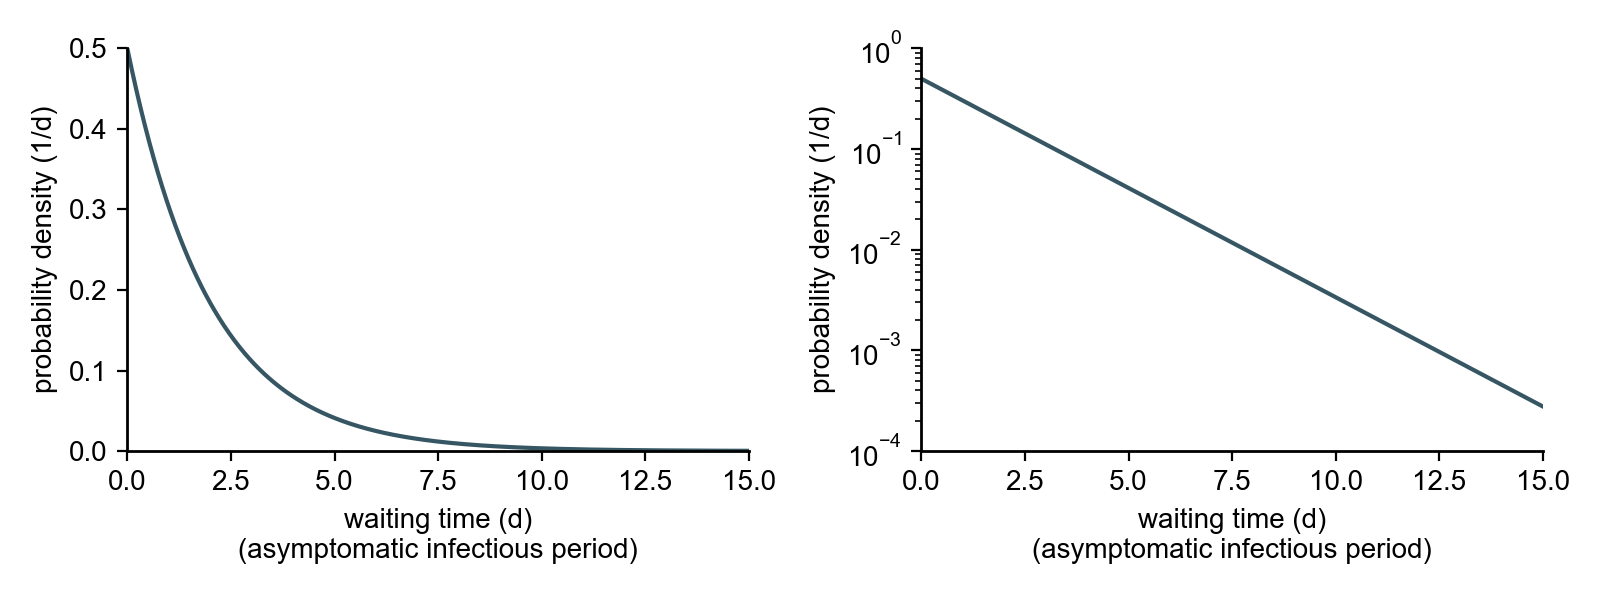

In [3]:
t = np.linspace(0,15,1001)
infectious_period = 2
mu = 1/infectious_period

def plot_on_two_ax(*args):
    fig, ax = pl.subplots(1,2,sharex=True,figsize=(8,3))
    for a in ax:
        for iy,y in enumerate(args):
            a.plot(t, y)
        a.set_xlabel('waiting time (d)\n(asymptomatic infectious period)')
        a.set_ylabel('probability density (1/d)')
    ax[1].set_yscale('log')
    fig.tight_layout()
    return ax
    
    
ax = plot_on_two_ax(mu*np.exp(-mu*t))

We can check the statements above intuitively: Assume there are $N=10^4$ individuals that just all became asymptomatically infectious at the same time. Now, for each of them, draw a waiting time from the exponential distriubtion.

In [4]:
#load exponential distributions
from scipy.stats import expon
distr = expon(scale=1/mu)

N = 10_000
waiting_times = distr.rvs(size=N)
print(f"{waiting_times[:10]=}")

waiting_times[:10]=array([3.22853663, 4.57545554, 1.01961799, 0.75342549, 0.80385071,
       2.15532353, 1.38962147, 0.06150351, 1.71598354, 1.26639674])


Let's plot a histogram of these:

<IPython.core.display.Javascript object>


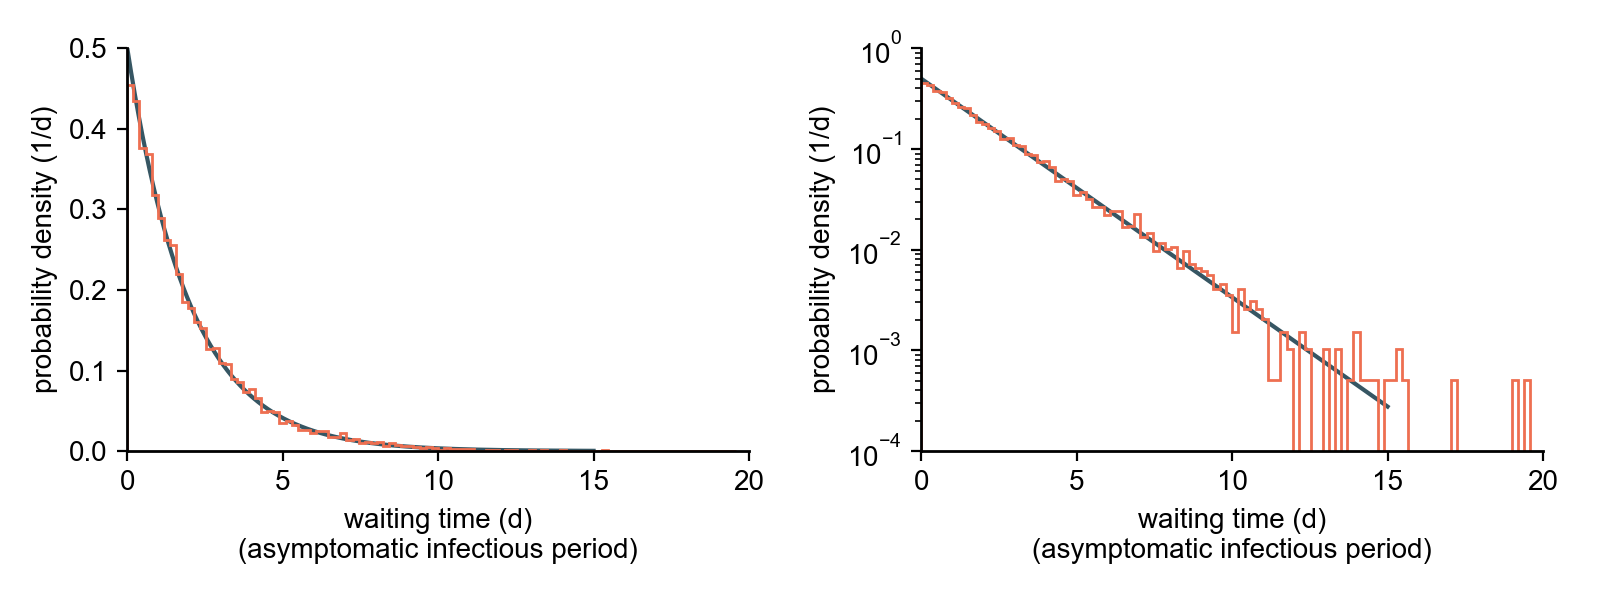

In [5]:
ax = plot_on_two_ax(mu*np.exp(-mu*t))
for a in ax:
    a.hist(waiting_times,bins=100,histtype='step',density=True)

Now, how many of the 10k individuals will still be asymptomatic after 1 day? This is the same question as "How much of $A$ is left after "1d" with $A(t=0)=N$? It is also the same question as for how many of the 10k individuals is the waiting time (asymp. infectious period) longer than a day? Answer:

In [6]:
individuals_that_are_still_in_A = np.where(waiting_times > 1)[0]
A_1d = len(individuals_that_are_still_in_A)
A_1d

6122

How many will be left after 2d?

In [7]:
individuals_that_are_still_in_A = np.where(waiting_times > 2)[0]
A_2d = len(individuals_that_are_still_in_A)
A_2d

3736

Now we can also ask how many are left after t days (for every entry in our `t`-array that we defined above) and call the result $A(t)$.

In [8]:
A_t = []
for _t in t:
    individuals_that_are_still_in_A = np.where(waiting_times > _t)[0]
    A_t.append(len(individuals_that_are_still_in_A))


<IPython.core.display.Javascript object>


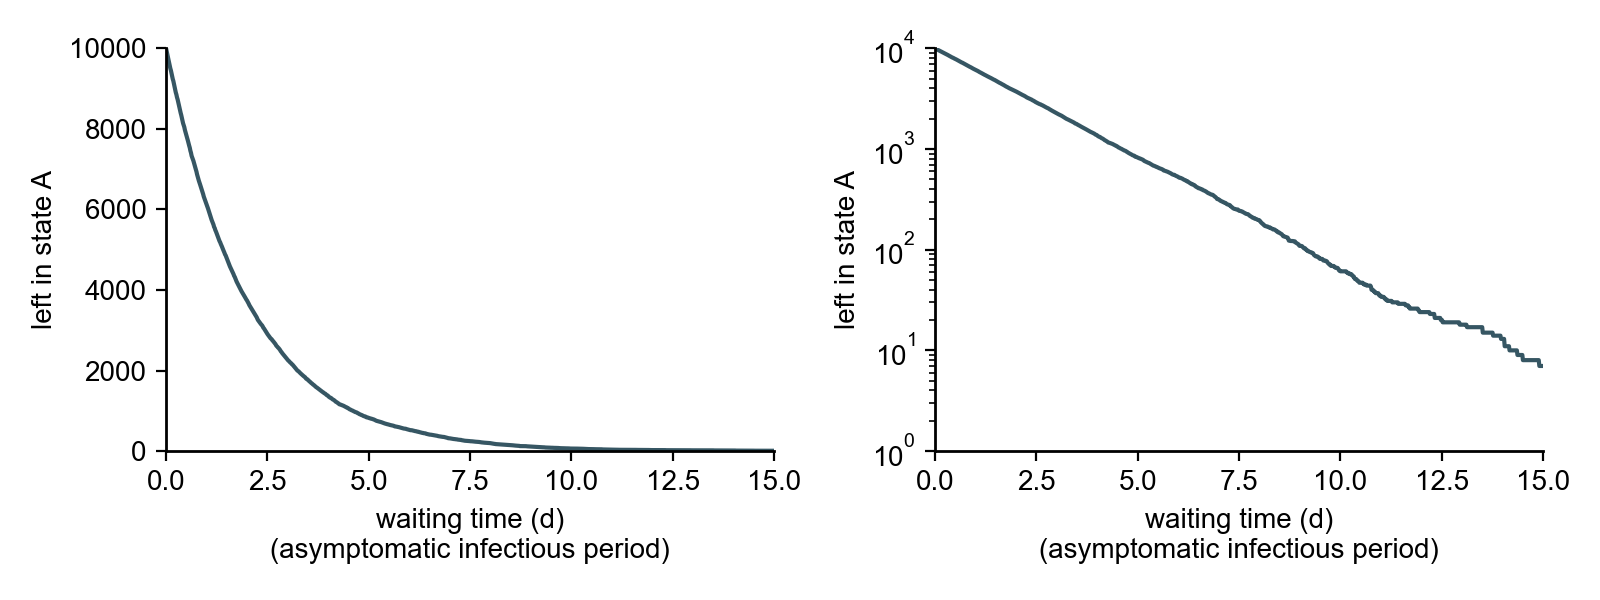

In [9]:
ax = plot_on_two_ax(A_t)
for a in ax:
    a.set_ylabel('left in state A')

What we computed here with random numbers is proportional to the complementary cumulative distribution function of $p(\tau)$, also called the "survival function", because when you think of "A" as "alive" and the waiting time as "duration of life", then this function is gives you the number of individuals that are still alive after a time "t" has passed. In fact, we find that

$$
\frac{1}{N} A(t) = 1 - \int^t_0 d\tau\ p(\tau),
$$
i.e.
$$
A(t) = N \exp(-\mu t),
$$

which is the solution to the ODE we started with. Let's define a symbolic epi model to show that.

The single transition process of this model is death, i.e.

$$
A\stackrel{\mu}{\longrightarrow}\emptyset.
$$

In [10]:
import sympy as sy
A, mu = sy.symbols('A mu')
model = epk.SymbolicEpiModel([A]).add_transition_processes([
        (A, mu, None),
    ])
model.ODEs_jupyter()

<IPython.core.display.Math object>

This is the ODE we defined above. Now let's solve it.

In [11]:
model.set_parameter_values({mu: 1/infectious_period})
model.set_initial_conditions({A: N})
result = model.integrate(t)

/Users/bfmaier/Dropbox/forschung/disease_dynamics/epipack/epipack/integrators.py:377: UserWarning: Sum of initial conditions does not equal unity.
  warnings.warn('Sum of initial conditions does not equal unity.')


All results plotted together:

<IPython.core.display.Javascript object>


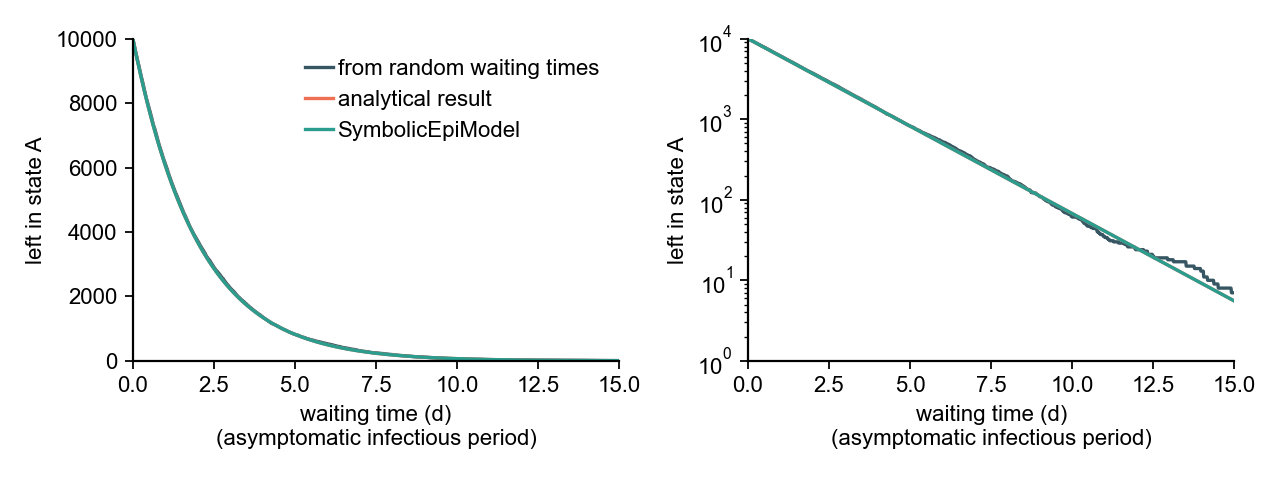

In [16]:
ax = plot_on_two_ax(
    A_t,
    N * np.exp(-t/infectious_period),
    result[A]
)
for a in ax:
    a.set_ylabel('left in state A')
    
ax[0].legend(['from random waiting times','analytical result','SymbolicEpiModel']);

Hard to distinguish, right?